# İleri Python Projesi: Cilt Kanseri Tespiti

- Bu proje, cilt kanserini tespit etmek için **TensorFlow** ile uygulanan **evrimsel sinir ağlarını** kullanır.

# Model Açıklaması


### Model, cilt lezyonlarının görüntülerini analiz etme ve bunların olup olmadığını belirleme yeteneğine sahiptir:
 - **Malign:** kanserli olabilecek lezyonlar.
- **İyi huylu**: Sağlık riski oluşturmayan lezyonlar.

# İşleyeş

- 1. **Veri Girişi**: Bir dizi cilt kanseri görüntüsü modele beslenir.
- 2. **Analiz**: Görüntü özelliklerini değerlendirmek için derin öğrenme tekniklerini kullanır.
- 3. **Sınıflandırma**: Model, cilt üzerindeki işaretin niteliğini belirler.


# Kütüphanelerin Yüklenmesi

In [1]:
#pip install xgboost


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image

K.clear_session()

In [3]:
train_folder = "data/train/"
test_folder = "data/test/"

In [4]:
# Bu fonksiyon, verilen bir klasör içindeki alt klasörlerde bulunan dosya sayılarını hesaplar ve her bir alt klasör için bu
# sayıları ekrana yazdırıildeyse:

def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))


There are 360 files in benign
There are 300 files in malignant


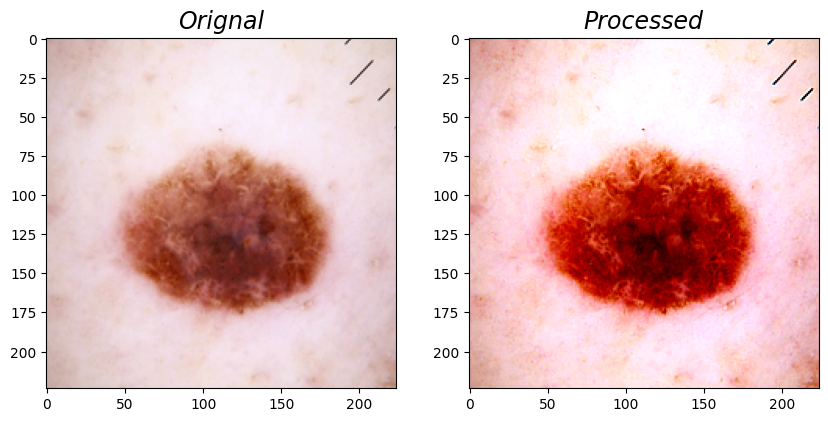

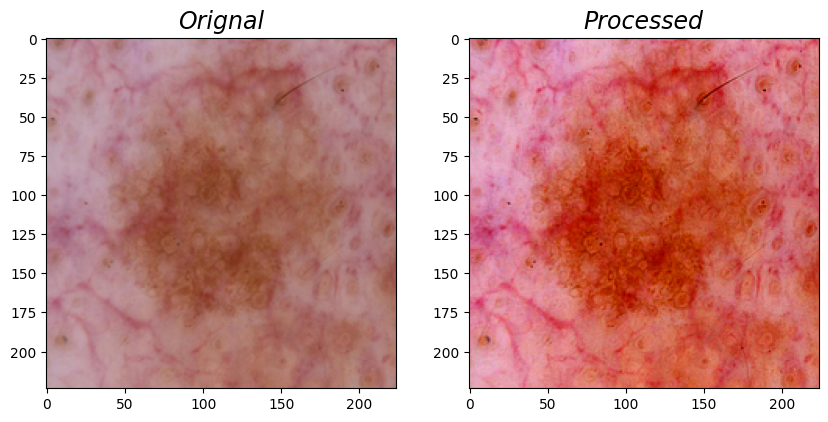

In [5]:
# Bu fonksiyon, bir klasör içerisinden rastgele seçilen görüntüler üzerinde basit görüntü işleme (renk, kontrast ve keskinlik artırma)
# işlemleri yapar ve orijinal görüntü ile işlenmiş görüntüyü yan yana görselleştirir.
image_folder="malignant"  
number_of_images=2     

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

# Görüntülerin Görselleştirilmesi
## Amaç:
Bu kod, belirli bir klasördeki görüntüleri belirtilen sayıda satır ve sütuna göre bir ızgara üzerinde görselleştirir. Görüntüler, kullanıcı tarafından seçilen klasörden alınır ve matplotlib ile ekranda gösterilir.

## Parametreler:
- `select_folder`: Görüntülerin bulunduğu klasörün adı (örnekte "malignant").
- `rows, columns`: Görselleştirmenin kaç satır ve sütun olarak yapılacağını belirler (örnekte 1 satır, 5 sütun).
- `train_folder`: Görüntülerin ana klasörü.


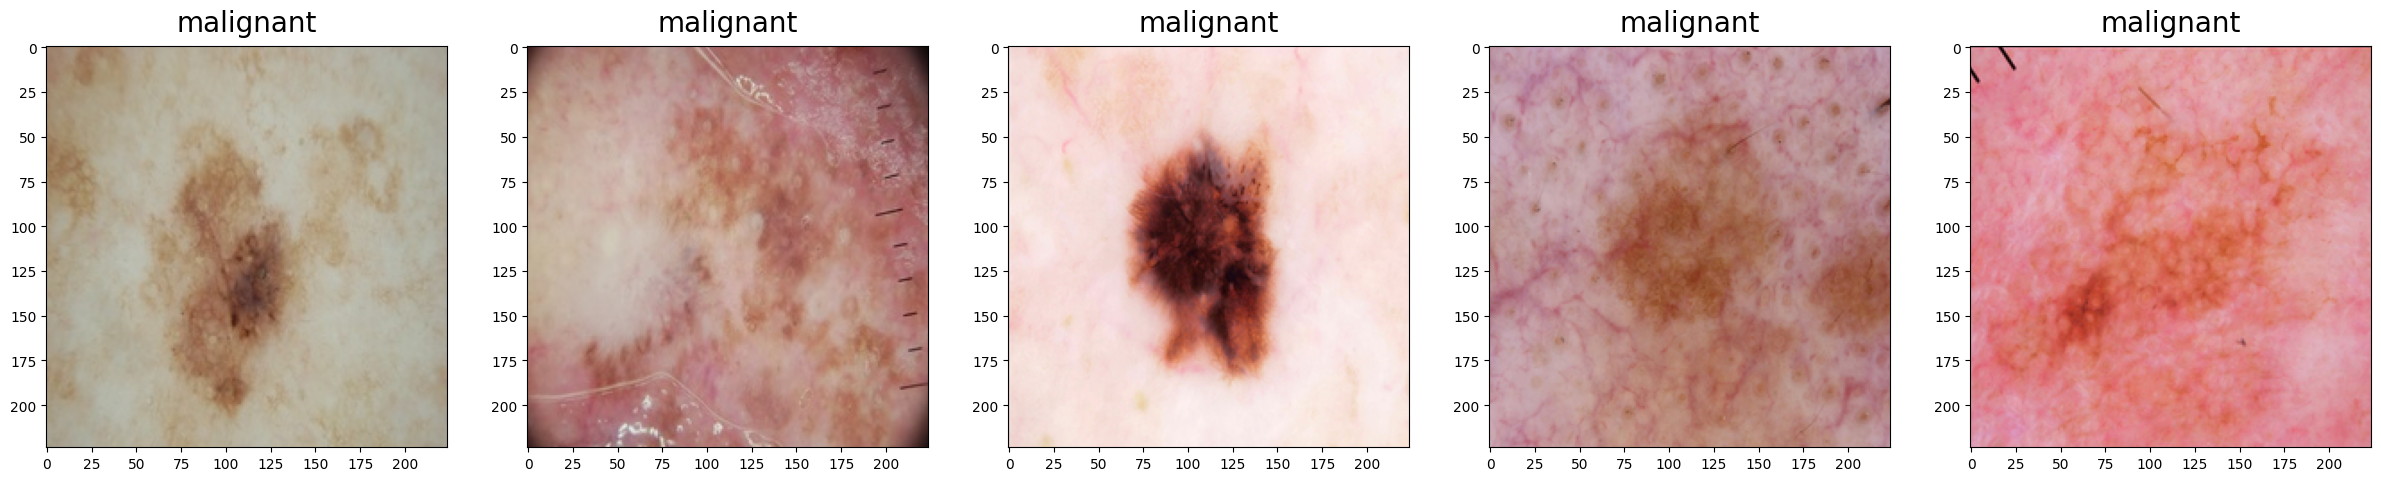

In [6]:
select_folder="malignant"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_folder)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_folder,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_folder, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

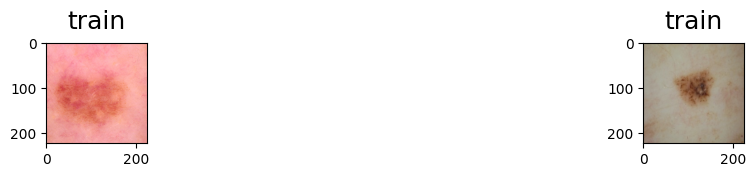

In [7]:
# Bu kod, belirtilen bir ana klasörün (örnekte `train_folder`) altındaki her klasörden rastgele bir görüntü seçer.
# Seçilen görüntüler kategorilere göre görselleştirilir.
images = []

for image_folder in sorted(os.listdir(train_folder)):
    leaf = os.listdir(train_folder + '/' + image_folder)
    img_selected = np.random.choice(leaf)
    images.append(os.path.join(train_folder,image_folder,img_selected))
                                     
fig=plt.figure(1, figsize=(30, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(7, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

In [8]:
# Bu kod parçaları, bir derin öğrenme modeli için kullanılan bazı temel hiperparametreleri ve giriş özelliklerini tanımlar.
n_cat =2

batch_size = 48
batch_size_predict = 128
input_shape = (299,299)


# Xception Modeli Tanımlama

In [9]:
# Bu kod parçaları, bir derin öğrenme modeli için kullanılan bazı temel hiperparametreleri ve giriş özelliklerini tanımlar.
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

# Model Katmanlarını Eğitilebilir Hale Getirme ve Kısmen Dondurma

In [10]:
# Bu kod, önceden eğitilmiş bir Xception modelinin katmanlarının hangi kısmının eğitileceğini (trainable) veya dondurulacağını (non-trainable)
# ayarlamak için kullanılır. Sonrasında modelin özet bilgisi ekrana yazdırılır.
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False   
    
x_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

# Genelleştirilmiş Ortalama Havuzlama (Generalized Mean Pooling) Fonksiyonu

In [11]:
# Bu kod, görüntü işleme modellerinde kullanılan genelleştirilmiş bir havuzlama yöntemi olan **Genelleştirilmiş Ortalama Havuzlama**
# (Generalized Mean Pooling, GeM) işlemini tanımlar. Standart havuzlama işlemlerinden (örneğin, `mean` veya `max`) daha esnek bir yapıya sahiptir.
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

# Modelin Üst Katmanlarını Tanımlama

In [14]:
# Bu kod, önceden eğitilmiş bir temel model (örneğin, **Xception**) üzerine eklenen bir **özel sınıflandırıcı katmanını** tanımlar.
# Bu sınıflandırıcı, genelleştirilmiş havuzlama yöntemini ve diğer katmanları kullanarak modelin nihai tahminlerini üretir.
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 lambda_2 (Lambda)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 activation (Activation)     (None, 2048)              0         
                              

# Nihai Modelin Tanımlanması

In [15]:
# Bu kod, önceden tanımlanmış bir temel model (**Xception**) ve onun üzerine eklenmiş özel bir sınıflandırıcı katmanını
# birleştirerek tam bir derin öğrenme modeli oluşturur. Model, verilen bir görüntü girişinden sınıf tahmini yapar.
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 model (Functional)          (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 11,634,410
Non-trainable params: 9,231,168
_________________________________________________________________


# Modelin Derlenmesi

In [16]:
# Bu adım, oluşturulan modelin eğitim için gerekli olan kayıp fonksiyonunu, optimizer'ı ve metrikleri tanımlar.
# Modelin eğitim işlemlerinin başlaması için bu adımın tamamlanması gerekir.
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # Daha düşük bir öğrenme oranı
    metrics=['accuracy']
)


# Eğitim ve Test Veri Kümesinin Hazırlanması

In [17]:
# Modeli eğitmek için eğitim ve test veri kümelerini hazırlamak ve eğitim sırasında veri augmentasyonu (veri çoğaltma)
# uygulayarak modelin genelleştirme yeteneğini artırmak.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim veri seti için augmentasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize [0, 1] aralığına
    rotation_range=20,  # Görüntüyü rastgele döndür
    width_shift_range=0.2,  # Görüntünün genişlik yönünde kaydır
    height_shift_range=0.2,  # Görüntünün yükseklik yönünde kaydır
    shear_range=0.2,  # Görüntü üzerinde eğim dönüşümleri uygula
    zoom_range=0.2,  # Görüntüyü yakınlaştır
    horizontal_flip=True,  # Görüntüleri yatay çevir
    fill_mode='nearest'  # Eksik piksel değerlerini en yakın komşudan doldur
)

# Test veri seti sadece normalize edilecek
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(299, 299),  # Modelin beklediği boyut
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    'data/test/',
    target_size=(299, 299),  # Modelin beklediği boyut
    batch_size=32,
    class_mode='categorical'
)
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input

# Modeli giriş boyutuna göre özelleştiriyoruz
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [18]:
class_map = training_set.class_indices
class_map

{'benign': 0, 'malignant': 1}

# Görüntü Sınıflandırma Projesi: Xception Modeli ile Eğitim ve Test Süreci
Bu proje, **Xception modelini** kullanarak görüntü sınıflandırması yapmak için eğitim ve test işlemlerini gerçekleştiren bir örnektir.


# Model Eğitim Sonuçlarının Görselleştirilmesi

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)  

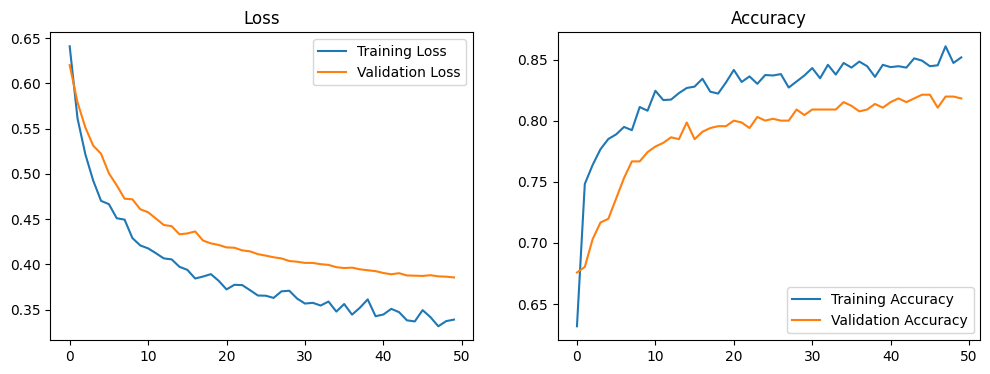

In [19]:
# Bu bölümde, model eğitim sürecinin doğruluk ve kayıp eğrileri çizilerek eğitim performansı görselleştirilecektir.
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 1. Veri Ön İşleme
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(299, 299),  # Xception modeline uygun boyut
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    'data/test/',
    target_size=(299, 299),  # Xception modeline uygun boyut
    batch_size=32,
    class_mode='categorical'
)

# 2. Model Tanımlama
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(len(training_set.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Sadece son katmanları eğitilecek şekilde donduralım
for layer in base_model.layers:
    layer.trainable = False
print(model.summary())
# Model derleme
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Sınıf Ağırlıklarının Hesaplanması
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes
)
class_weights_dict = dict(enumerate(class_weights))

# 4. Eğitim Ayarları
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelin eğitilmesi
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# 5. Sonuçların Görselleştirilmesi
plt.figure(figsize=(12, 4))

# Kayıp Eğrisi
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Doğruluk Eğrisi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


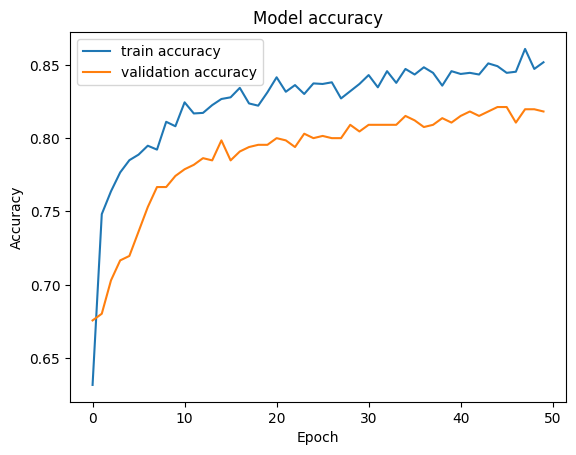

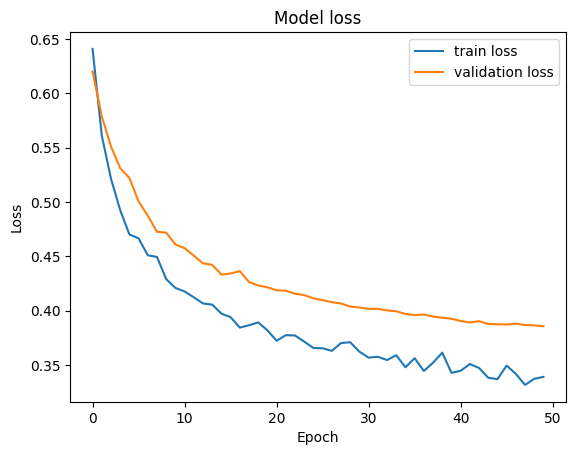

In [22]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

# Doğru değişkeni geçiriyoruz
plot_accuracy(history)
plot_loss(history)


In [23]:
# Test veri kümesini kullanma
score = model.evaluate(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 3s 155ms/step - loss: 0.3857 - accuracy: 0.8182
Test loss: 0.38572147488594055
Test accuracy: 0.8181818127632141


# Modelin Test Performansının Değerlendirilmesi

In [24]:
# Bu işlemle modelin eğitim sonrasında doğrulama (test) veri kümesi üzerinde doğruluk ve kayıp değerleri hesaplanarak test performansı ölçülecek.
validation_data_dir = 'data/test/'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)

# evaluate yerine
scores = model.evaluate(validation_generator)

print("Test Accuracy: {:.3f}".format(scores[1]))


Found 660 images belonging to 2 classes.
11/11 [==============================] - 3s 287ms/step - loss: 0.3857 - accuracy: 0.8182
Test Accuracy: 0.818


# Görüntü Sınıflandırma ve Doğruluk Değerlendirme


In [25]:
category={
    0:'benign',1:'malignant'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

1/1 [==============================] - 1s 733ms/step


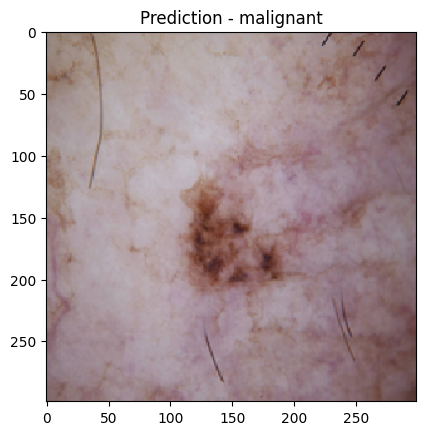

In [26]:
predict_image(os.path.join(validation_data_dir,'malignant/1027.jpg'),model)

1/1 [==============================] - 0s 21ms/step


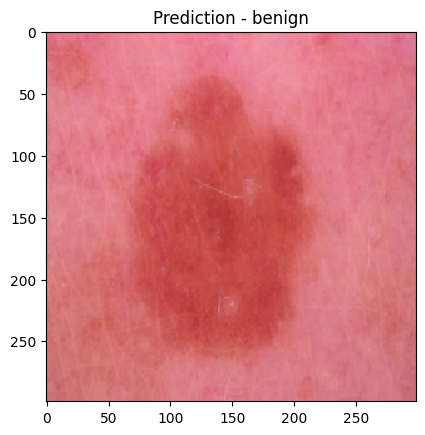

In [27]:
predict_image(os.path.join(validation_data_dir,'benign/1042.jpg'),model)

# Karışıklık Matrisi ve Görselleştirme

- `labels_confusion_matrix` Fonksiyonu

In [28]:
# Bu işlemle modelin eğitim sonrasında doğrulama (test) veri kümesi üzerinde doğruluk ve kayıp değerleri hesaplanarak test performansı ölçülecek.
def labels_confusion_matrix(test_folder):
    
    folder_path=test_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) 
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 25ms/step


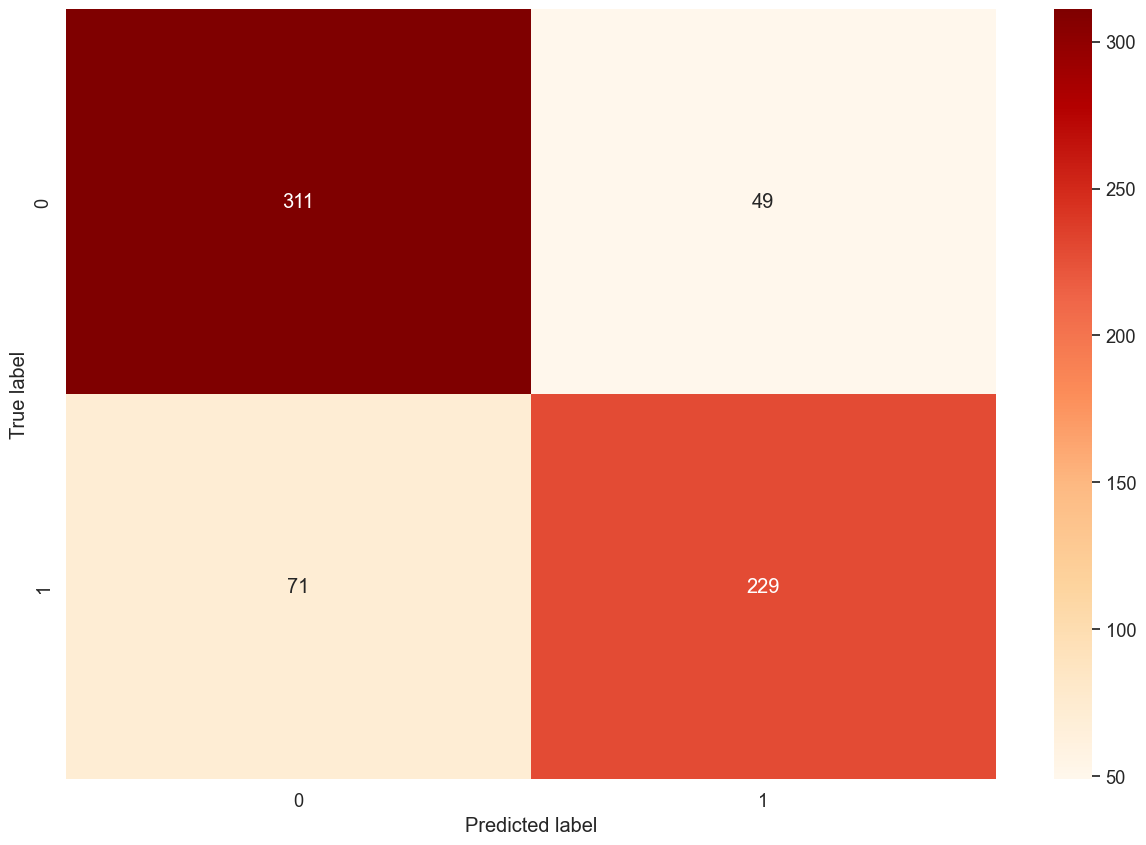

In [29]:
y_true,y_pred=labels_confusion_matrix(test_folder)
print_confusion_matrix(y_true,y_pred)

# Modeli kaydetme
model.save("skin_cancer_detection_model.h5")


print("Model başarıyla kaydedildi!") 


her seferinde kaydedilmemesi için buraya yazıldı.

# Xgboost

Found 2637 images belonging to 2 classes.
83/83 [==============================] - 7s 69ms/step
Accuracy: 0.8788
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       283
           1       0.85      0.90      0.87       245

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528



<Figure size 1000x800 with 0 Axes>

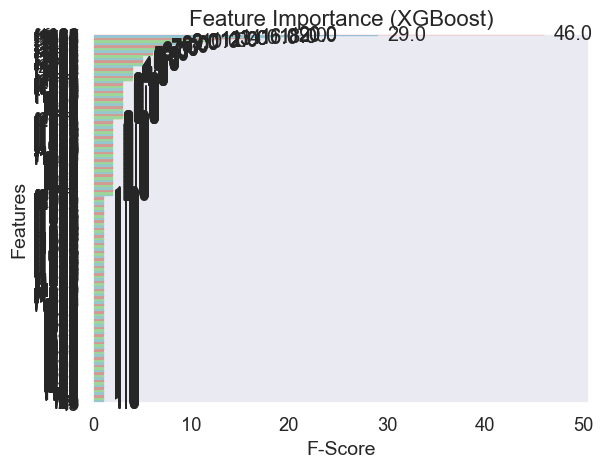

In [30]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Define paths
train_dir = 'data/train'
test_dir = 'datatest'

# Load ResNet50 model pre-trained on ImageNet, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Set up image data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create a generator for the training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Extract features using ResNet50
features = base_model.predict(train_generator)
labels = train_generator.classes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# If you'd like to plot feature importance
import matplotlib.pyplot as plt

# Plot feature importance with customization
plt.figure(figsize=(10, 8))
ax = xgb.plot_importance(xgb_model, importance_type='weight', color='skyblue', height=0.8)

# Customize the plot to make it colorful
ax.set_title('Feature Importance (XGBoost)', fontsize=16)
ax.set_xlabel('F-Score', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.grid(False)

# Set different colors for bars
for i, bar in enumerate(ax.patches):
    if i % 3 == 0:
        bar.set_color('skyblue')
    elif i % 3 == 1:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightgreen')

plt.show()

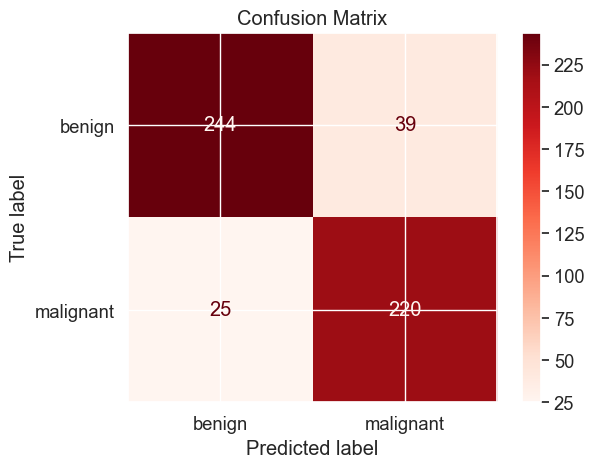

In [31]:
# Xgoost confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_generator.class_indices.keys())
disp.plot(cmap='Reds', values_format='d')

plt.title('Confusion Matrix')
plt.show()
